In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
train = session.query(REGULATOR).filter(REGULATOR.split == 0).all()
dev = session.query(REGULATOR).filter(REGULATOR.split == 1).all()
test = session.query(REGULATOR).filter(REGULATOR.split == 2).all()
unlab = session.query(REGULATOR).filter(REGULATOR.split == 3).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))
print('Unlab set:\t{0} candidates'.format(len(unlab)))

Training set:	12987 candidates
Dev set:	3230 candidates
Test set:	8335 candidates
Unlab set:	79400 candidates


In [3]:
import numpy as np

In [4]:
from snorkel.annotations import load_marginals
train_labels = np.array([0 if train[x].gold_labels[0].value ==-1 else 1 for x in range(len(train))]) # load train labels to mix in LSTM
unlab_marginals = load_marginals(session, split=3)


In [7]:
with open("L_train_us_mod8", 'rb') as f:
    unlab, unlab_marginals = pickle.load(f)

In [36]:
unlab

<10208x12 sparse matrix of type '<type 'numpy.int64'>'
	with 122496 stored elements in Compressed Sparse Row format>

In [24]:
len(unlab_marginals)

10208

In [8]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [10]:
from snorkel.learning import reRNN

In [29]:
from MLutils import balance_candidates

In [30]:
# unlab_us,unlab_marginals_us = balance_candidates(unlab,unlab_marginals)

# # TODO: balance candidates also in training set (change train_unlab_marginals below + train -> train_us in lstm.train)
train_us, train_labels_us = balance_candidates(train,train_labels)

train_unlab_marginals = np.append(train_labels_us, unlab_marginals)

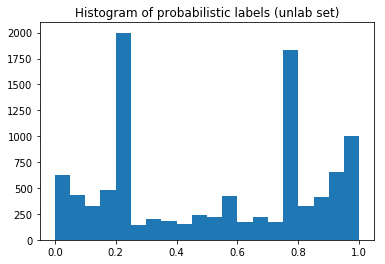

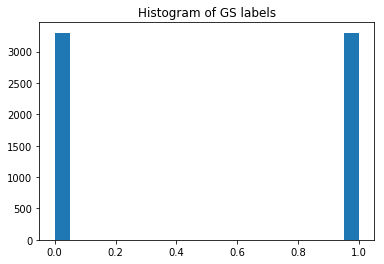

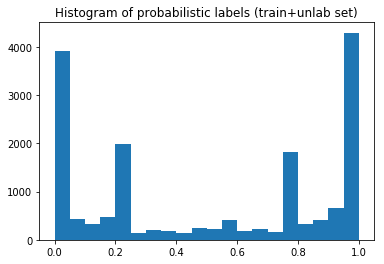

In [31]:
import matplotlib.pyplot as plt
plt.hist(unlab_marginals, bins=20, range=[0,1])
plt.title('Histogram of probabilistic labels (unlab set)')
plt.show()

import matplotlib.pyplot as plt
plt.hist(train_labels_us, bins=20, range=[0,1])
plt.title('Histogram of GS labels')
plt.show()

# plt.hist(unlab_marginals_us, bins=20, range=[0,1])
# plt.title('Histogram of probabilistic labels (unlab set, undersampled)')
# plt.show()

# plt.hist(train_labels_us, bins=20)
# plt.title('Histogram of labels (train set)')
# plt.show()

plt.hist(train_unlab_marginals, bins=20)
plt.title('Histogram of probabilistic labels (train+unlab set)')
plt.show()


** train on unlab **

In [33]:
type(train_us)

list

In [37]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   35,
    'dropout':    0.5,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64
}

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(unlab, unlab_marginals, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

In [22]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.401
Neg. class accuracy: 0.633
Precision            0.234
Recall               0.401
F1                   0.296
----------------------------------------
TP: 283 | FP: 926 | TN: 1599 | FN: 422



In [23]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.43
Neg. class accuracy: 0.599
Precision            0.251
Recall               0.43
F1                   0.317
----------------------------------------
TP: 854 | FP: 2547 | TN: 3801 | FN: 1133



** train on GS + unlab **

In [24]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   35,
    'dropout':    0.5,
    'rebalance':  False,
    'print_freq': 1,
    'batch_size': 64
}

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(train_us+unlab, train_unlab_marginals, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=32234  #epochs=35  batch size=64
[reRNN] Epoch 0 (174.60s)	Average loss=0.684336	Dev F1=31.44
[reRNN] Epoch 1 (353.59s)	Average loss=0.649195	Dev F1=38.84
[reRNN] Epoch 2 (533.47s)	Average loss=0.622957	Dev F1=32.80
[reRNN] Epoch 3 (713.76s)	Average loss=0.606986	Dev F1=34.70
[reRNN] Epoch 4 (893.71s)	Average loss=0.596704	Dev F1=38.08
[reRNN] Epoch 5 (1073.09s)	Average loss=0.590982	Dev F1=34.26
[reRNN] Epoch 6 (1252.19s)	Average loss=0.584493	Dev F1=33.46
[reRNN] Epoch 7 (1429.63s)	Average loss=0.580822	Dev F1=32.67
[reRNN] Epoch 8 (1608.54s)	Average loss=0.578330	Dev F1=34.23
[reRNN] Epoch 9 (1786.85s)	Average loss=0.579898	Dev F1=33.53
[reRNN] Epoch 10 (1965.11s)	Average loss=0.575107	Dev F1=36.36
[reRNN] Epoch 11 (2144.29s)	Average loss=0.571064	Dev F1=33.46
[reRNN] Epoch 12 (2324.36s)	Average loss=0.566449	Dev F1=31.69
[reRNN] Epoch 13 (2503.89s)	Average loss=0.567328	Dev F1=34.15
[reRNN] Epoch 14 (2682.48s)	Average loss=0.565605	Dev F1=32.7

In [25]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.416
Neg. class accuracy: 0.707
Precision            0.283
Recall               0.416
F1                   0.337
----------------------------------------
TP: 293 | FP: 741 | TN: 1784 | FN: 412



In [26]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.445
Neg. class accuracy: 0.703
Precision            0.319
Recall               0.445
F1                   0.372
----------------------------------------
TP: 885 | FP: 1885 | TN: 4463 | FN: 1102



# Check actual end-model score

In [13]:
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<8335x1 sparse matrix of type '<type 'numpy.int64'>'
	with 8335 stored elements in Compressed Sparse Row format>

In [28]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.608
Neg. class accuracy: 0.54
Precision            0.293
Recall               0.608
F1                   0.395
----------------------------------------
TP: 1208 | FP: 2918 | TN: 3430 | FN: 779

